# Manipulate bathymetry data

There is very high resolution bathymetry data [available](http://www.ngdc.noaa.gov/mgg/coastal/) for Galveston Bay. It is too large to use on a lightweight machine, so I decimated it, taking every fifth cell, and saved it as a .npz file called `bathy_every_fifth.npz`. This has been saved to Google Drive folder "Harvey Flooding" for sharing.

This notebook produces bathymetry files for all of Galveston Bay, the main bay alone, the west bay, and the east bay, all in .npz format. These files have already been saved into the `drive_data` directory.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from matplotlib.path import Path

In [2]:
# create arrays of lon/lat
num = 10261
dd = 9.2592589999999e-005
xllcorner = -95.250046296295
yllcorner = 28.849953716305
x = np.linspace(xllcorner, xllcorner+dd*num, num)
y = np.linspace(yllcorner, yllcorner+dd*num, num)
lon, lat = np.meshgrid(x, y)

# use every fifth bathymetry point
# bathymetry was decimated on hafen and scp'ed to here
# same as the file in `Galveston_DEM_1072`
bathy = np.load('drive_data/bathy_every_fifth.npz')['bathy'][::-1,:]
lon = lon[::5, ::5]
lat = lat[::5, ::5]

## Galveston Bay bathymetry

Separate the bay bathymetry out from the topography, and retain only values in the bay.

In [3]:
bathyfilename = 'drive_data/bathy_galv.npz'
galvpathfilename = 'drive_data/galvpath.npz'

# only redo path creation if file doesn't exist
if not os.path.exists(galvpathfilename):
    
    # use previously-clicked points along coast to separate bathymetry outside galveston bay
    d = np.load('drive_data/coastpts.npz')  # from shelf_transport/calcs

    # remove lat/lon away from g bay
    inds = (d['lon']>lon.min()) * (d['lon']<lon.max())
    lonpts = d['lon'][inds]; latpts = d['lat'][inds]

    # make path around galveston bay
    lonpts = np.hstack((lonpts, lon.max(), lon.min(), lon.min()))
    latpts = np.hstack((latpts, 29.8, 29.8, latpts.min()))
    pts = np.vstack((lonpts, latpts)).T
    path = Path(pts)
    np.savez(galvpathfilename, path=path)
    
else:
    path = np.load(galvpathfilename)['path'].item()
    

# only redo analysis if file doesn't exist
if not os.path.exists(bathyfilename):
    
    # remove data points outside path around Galveston Bay
    inds = ~path.contains_points(np.vstack((lon.flatten(), lat.flatten())).T).reshape(lon.shape)
    bathy[inds] = np.nan
    
    # remove topography (>0)
    inds = bathy>0
    bathy[inds] = np.nan
    
    # Assume that the cell sizes stay about the same throughout the data set
    pc = cartopy.crs.PlateCarree()
    laea = cartopy.crs.LambertAzimuthalEqualArea()
    pts = laea.transform_points(pc, lon, lat)
    xp = pts[:,:,0]; yp  = pts[:,:,1]
    dx = np.diff(xp[0,:]).mean()
    dy = np.diff(yp[:,0]).mean()

    np.savez(bathyfilename, bathy=bathy, lon=lon, lat=lat, dx=dx, dy=dy)

else:
    
    d = np.load(bathyfilename)
    bathy = d['bathy']; lon = d['lon']; lat = d['lat']; dx = d['dx']; dy = d['dy']

/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


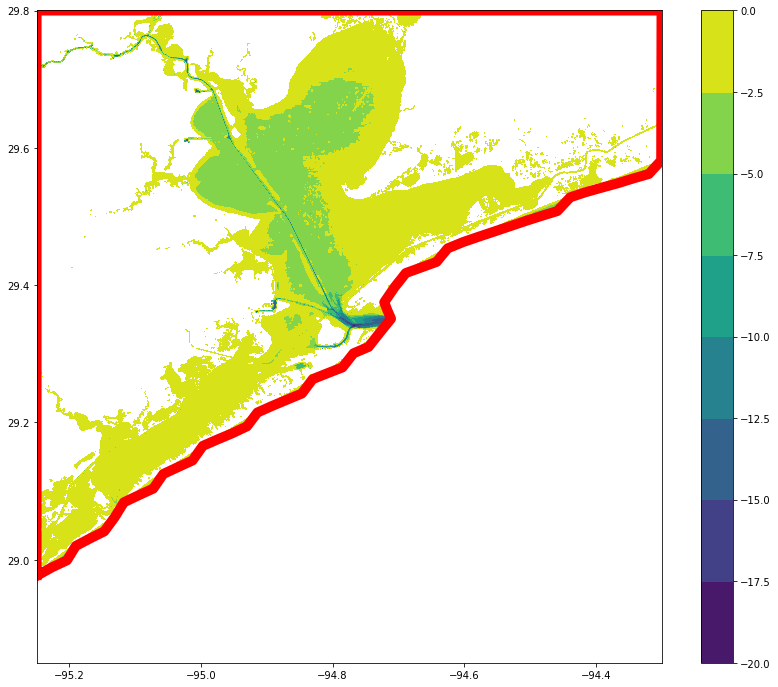

In [4]:
# coast
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy); 
fig.colorbar(mappable)
ax.plot(path.vertices[:,0], path.vertices[:,1], 'r', lw=10)

## West and East bays

In [5]:
# separate out main bay over a few calculations
bathym = bathy.copy()

# west bay
inds = ((lat<29.4) * (lon<-94.9)) | ((lat<29.37) * (lon<-94.87)) | ((lat<29.365) * (lon<-94.825))
bathyw = bathy.copy()
# remove the west bay 
bathym[inds] = np.nan  # for main bay
bathyw[~inds] = np.nan  # for west bay
np.savez('drive_data/bathy_galv_west.npz', bathy=bathyw, lon=lon, lat=lat, dx=dx, dy=dy)

# east bay
inds = ((lat<29.55) * (lon>-94.75) * (lat>29.37)) | ((lat<29.8) * (lon>-94.69)) #| ((lat<29.365) * (lon<-94.825))
bathye = bathy.copy()
bathym[inds] = np.nan  # for main bay
bathye[~inds] = np.nan  # east bay
np.savez('drive_data/bathy_galv_east.npz', bathy=bathye, lon=lon, lat=lat, dx=dx, dy=dy)
np.savez('drive_data/bathy_galv_main.npz', bathy=bathy, lon=lon, lat=lat, dx=dx, dy=dy)

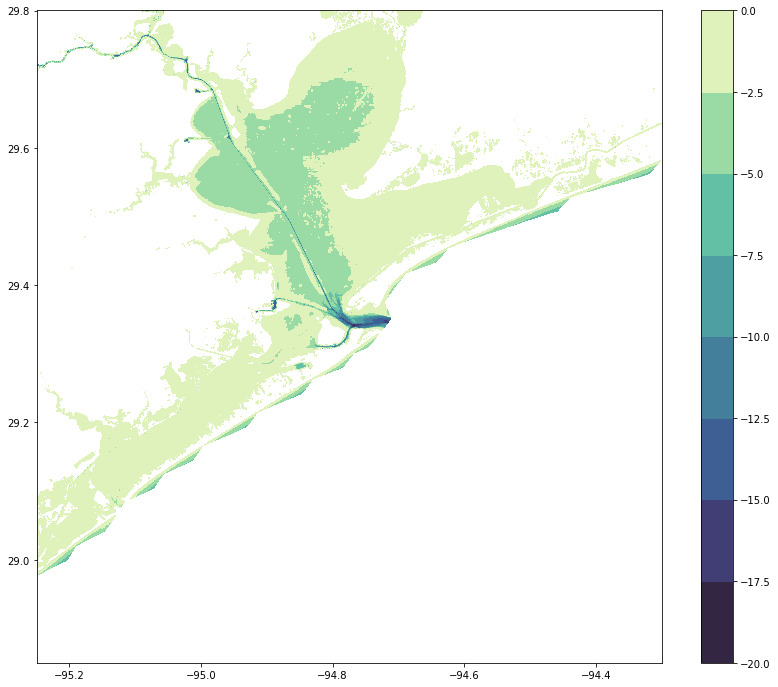

In [6]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
fig.colorbar(mappable)

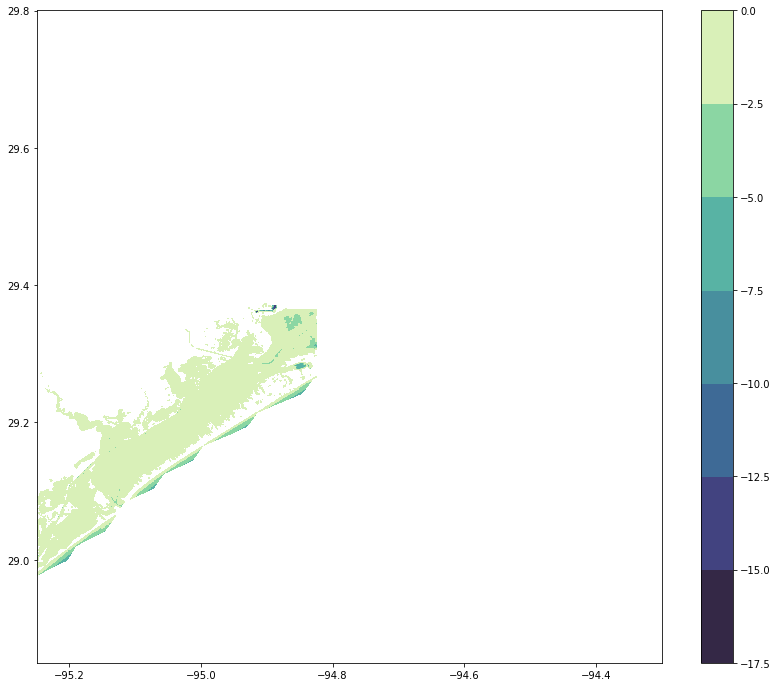

In [7]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathyw, cmap=cmo.deep_r); 
fig.colorbar(mappable)

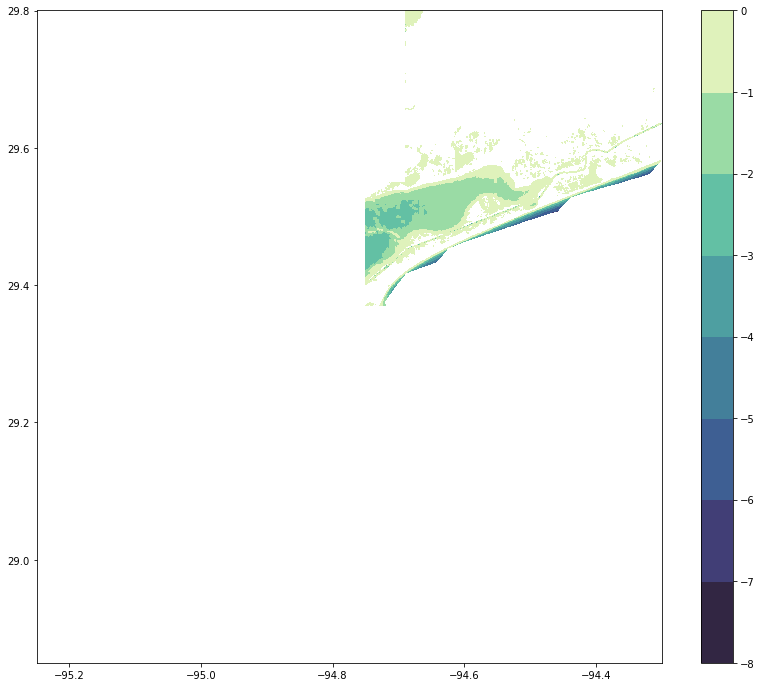

In [8]:
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathye, cmap=cmo.deep_r); 
fig.colorbar(mappable)


# Surface area

## All of Galveston Bay

Assuming that there wasn't a significant amount of new land flooded, the surface area of Galveston Bay is about 1200 km$^2$:

In [9]:
np.nansum(~np.isnan(bathy)*dx*dy)/(1000**2)  # km^2

1269.7529202644398

## Main bay

About 700 km$^2$.

In [10]:
np.nansum(~np.isnan(bathym)*dx*dy)/(1000**2)  # km^2

733.39665413903333

## West Bay

About 300 km$^2$.

In [11]:
np.nansum(~np.isnan(bathyw)*dx*dy)/(1000**2)  # km^2

321.17170688889775

## East Bay

About 200 km$^2$.

In [12]:
np.nansum(~np.isnan(bathye)*dx*dy)/(1000**2)  # km^2

215.18455923650819